In [1]:
# Reddit data analysis task starter.
import html
import json
import string
import re
import nltk
import praw
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# First collect the data in json-file (follow reddit_collect_data.ipynb); specify file name here
fjson = 'raw_post_comment_data.json'

In [3]:
# read json file with collected posts and comments
# https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files
with open(fjson) as file:
    data = json.load(file)
len(data)

50

In [4]:
# data record example
data[0]

{'id': 's4zw6m',
 'title': 'Unionizing your store: A how to guide',
 'text': "Hey everyone! \n\nI’ve been on this subreddit for a while and it seems like every day now we’re getting 3 types of posts. 1) New store unionizing!! 2) Peeps asking about unionizing and how to begin. Or 3) comments on horror stories telling the op to unionize.\n\nI’m an organizer at one of the newer stores to have filed to unionize, and I want to share with you the very broad strokes of how we got the ball rolling. The whole idea seemed so nebulous and scary at first, but once you have your partners on board, it’s actually surprisingly easy to start. I hope that sharing my experience will make the whole thing less intimidating.\n\nAlso: you may have your opinions on whether or not Unionizing is right for you. This post isn’t really about that conversation. This is just to help people who DO want to unionize figure out where to start. Please be nice.\n\n**Step one: Reach out.**\n\nNo seriously. If you are even 

In [5]:
# create pandas dataframe from post titles
# https://stackoverflow.com/a/43175477
df_posts = pd.DataFrame([p['title'] for p in data], columns=['title'])
df_posts

,title
0,Unionizing your store: A how to guide
1,To the woman who ordered a white chocolate moc...
2,aw hell nah these orders be getting too compli...
3,I walked out today!
4,Is a nitro cold brew worth it?
5,made me lol
6,Yes… We confirmed her drink at least 5 times
7,partners who wear white shoes to work pls show...
8,charging for water?
9,me sleeping until the hour in a half my shift ...


In [6]:
# add columns from other data fields: combine comment and sub-comment text
df_posts['post_id'] = [p['id'] for p in data]
df_posts['text'] = [p['text'] for p in data]
df_posts['comments_lev1'] = [' '.join(p['comments_lev1']) for p in data]
df_posts['comments_lev2'] = [' '.join(p['comments_lev2']) for p in data]
df_posts

,title,post_id,text,comments_lev1,comments_lev2
0,Unionizing your store: A how to guide,s4zw6m,Hey everyone! \n\nI’ve been on this subreddit ...,As a customer I would love a company wide unio...,"If you have a union store near you, go to that..."
1,To the woman who ordered a white chocolate moc...,wc90sk,I will never forget you or what you’ve done to...,"🤨 confused lmaooooo what a savage, she's gonna...",Dome hole. No! She was like eating the whip ju...
2,aw hell nah these orders be getting too compli...,wbx943,,"Really, that alpha particle lady again? Sheesh...","""Ummm, I actually asked for my alpha particles..."
3,I walked out today!,wc3ah1,I left halfway through my shift. I left my key...,Supervisor or manager? Just curious. Congrats...,"Supervisor. Dude, same! Inquiring minds, OP, p..."
4,Is a nitro cold brew worth it?,wbz2dz,,Don’t mobile order nitros unless the store you...,I had a regular that would mobile a nitro and ...
5,made me lol,wccrrb,,That’s called a venti.\n*loads Caramel Glock-i...,
6,Yes… We confirmed her drink at least 5 times,wcauvf,,Maybe that’s the strawberry ass-y that I keep ...,"it's like people that specify ""pink drink with..."
7,partners who wear white shoes to work pls show...,wc1i3c,,i tried to wear white shoes and was told immed...,bro why it’s in dress code😭😭 Absolutely. My p...
8,charging for water?,wcb4vn,i was just told by management today that i nee...,How do they expect you to charge for h2o? You ...,oh okay this makes sense :/ i’m in a licensed ...
9,me sleeping until the hour in a half my shift ...,wc0s34,,me sleeping in until 12:30 before my 1:30 shif...,I be sleeping until 5:00 when I start at 5:30 ...


In [7]:
# text cleaning function: see prior class modules
stop_words = nltk.corpus.stopwords.words('english')
new_stop_words = ['hey','everyone','ive','subreddit','every','day','getting','new','unionizing','peeps',
                  'asking','begin','horror','op','stories','telling','unionize','im','organizer','one',
                  'broad','newer','filed','want','share','broad','strokes','got','whole','idea','seemed',
                  'nebulous','scary','first','board','actually','suprisingly','easy','start','hope',
                  'sharing','experience','make','think','less','intimidating','may','whether','right','post',
                  'isnt','really','conversation','figure','step','reach','seriously','even','thinking',
                  'wanting','theyre','twitter','sbworkersunited','advice','stage','likely','theres','thats',
                  'already','organizing','put','contact','spoken','four','past','couple','RIP','cats','tiktok','why',
                  'meme','bojack','dumping','fuck','advice','gon','na','kno','cuz','trenta','rant','sensitive',
                  'documentation','pregnancy','honest','mistake','shit','love','u','time','know','partner','get','much','someone',
                  'need','thing','lol','still','looks','like','union','dues']

stop_words.extend(new_stop_words)

# strictly speaking, this is a closure: uses a wider-scope variable stop_words
# (disregard this note if you are a Python beginner)
def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

In [8]:
# add clean text column with combined comments of both levels
# NOTE: apply in pandas applies a function to each element of the selected column
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
df_posts['text_clean'] = (df_posts['text'] + df_posts['comments_lev1'] + df_posts['comments_lev2']).apply(text_cleanup)
df_posts

,title,post_id,text,comments_lev1,comments_lev2,text_clean
0,Unionizing your store: A how to guide,s4zw6m,Hey everyone! \n\nI’ve been on this subreddit ...,As a customer I would love a company wide unio...,"If you have a union store near you, go to that...",seems 3 types posts 1 store 2 3 comments store...
1,To the woman who ordered a white chocolate moc...,wc90sk,I will never forget you or what you’ve done to...,"🤨 confused lmaooooo what a savage, she's gonna...",Dome hole. No! She was like eating the whip ju...,never forget youve done eyes confused lmaooooo...
2,aw hell nah these orders be getting too compli...,wbx943,,"Really, that alpha particle lady again? Sheesh...","""Ummm, I actually asked for my alpha particles...",alpha particle lady sheesh quadratic formula f...
3,I walked out today!,wc3ah1,I left halfway through my shift. I left my key...,Supervisor or manager? Just curious. Congrats...,"Supervisor. Dude, same! Inquiring minds, OP, p...",left halfway shift left keys walked mental hea...
4,Is a nitro cold brew worth it?,wbz2dz,,Don’t mobile order nitros unless the store you...,I had a regular that would mobile a nitro and ...,dont mobile order nitros unless store order fr...
5,made me lol,wccrrb,,That’s called a venti.\n*loads Caramel Glock-i...,,called venti loads caramel lmfaooooooooo dont ...
6,Yes… We confirmed her drink at least 5 times,wcauvf,,Maybe that’s the strawberry ass-y that I keep ...,"it's like people that specify ""pink drink with...",maybe strawberry keep hearing feel specificy w...
7,partners who wear white shoes to work pls show...,wc1i3c,,i tried to wear white shoes and was told immed...,bro why it’s in dress code😭😭 Absolutely. My p...,tried wear white shoes told immediately idk pa...
8,charging for water?,wcb4vn,i was just told by management today that i nee...,How do they expect you to charge for h2o? You ...,oh okay this makes sense :/ i’m in a licensed ...,told management today needed charging people w...
9,me sleeping until the hour in a half my shift ...,wc0s34,,me sleeping in until 12:30 before my 1:30 shif...,I be sleeping until 5:00 when I start at 5:30 ...,sleeping shift half hour live nice barista rea...


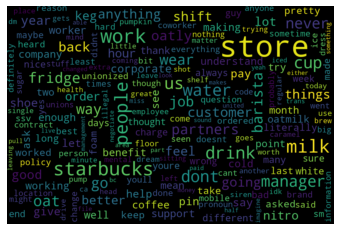

In [9]:
# most common keywords
# https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
text_combined = ' '.join(df_posts['text_clean'])
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(text_combined)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [10]:
# extract keyword counts
# https://stackoverflow.com/questions/60234036/python-word-count-from-wordcloud
kwords = WordCloud().process_text(text_combined)
kwords

{'posts': 1,
 'store': 220,
 'ball': 1,
 'partners': 35,
 'surprisingly': 2,
 'help': 23,
 'people': 56,
 'please': 7,
 'nice': 17,
 'starbucks': 62,
 'email': 8,
 'close': 6,
 'helped': 1,
 'answer': 4,
 'swu': 3,
 'materials': 2,
 'useful': 2,
 'tools': 2,
 'stuff': 12,
 'talking': 4,
 'fence': 2,
 'corporate': 24,
 'using': 2,
 'bust': 1,
 'unions': 12,
 'lot': 28,
 'helpful': 3,
 'empowering': 1,
 'information': 12,
 'willing': 3,
 'give': 24,
 'two': 20,
 'talk': 7,
 'important': 6,
 'rest': 7,
 'paperwork': 1,
 'point': 20,
 'band': 1,
 'together': 2,
 'negotiate': 9,
 'workplace': 4,
 'better': 28,
 'person': 13,
 'trust': 1,
 'build': 1,
 'lucky': 2,
 'basically': 5,
 'waiting': 6,
 'hand': 7,
 'card': 5,
 'realized': 1,
 'sent': 3,
 'everyones': 1,
 'different': 18,
 'aggressively': 1,
 'might': 12,
 'simply': 2,
 'see': 23,
 'situation': 4,
 'recommend': 5,
 'least': 14,
 'organize': 3,
 'us': 47,
 'shared': 2,
 'group': 1,
 'text': 4,
 'message': 4,
 'discussed': 1,
 'everyt

In [11]:
# transform that dictionary into a pandas DataFrame
df_kwords = pd.DataFrame(list(kwords.items()), columns=['keyword', 'count']).set_index('keyword')
df_kwords

,count
keyword,
posts,1
store,220
ball,1
partners,35
surprisingly,2
...,...
guys oatly,7
milk fridge,8
miss oatly,4


<AxesSubplot:xlabel='keyword'>

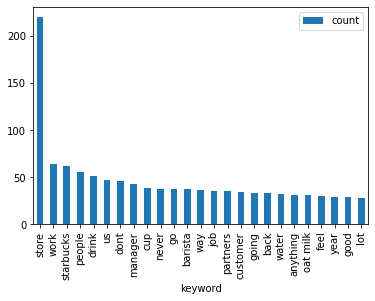

In [12]:
# plot a bar chart with the top keywords
%matplotlib inline
df_kwords.sort_values(by='count', ascending=False).head(25).plot.bar()

In [13]:
# NLTK collocations search (words occuring together): bigrams
# https://www.nltk.org/howto/collocations.html
# http://www.nltk.org/api/nltk.html#nltk.util.bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_documents([d.split() for d in df_posts['text_clean']])

In [14]:
# filter out bigrams occurring less than three times in the combined text
bigram_finder.apply_freq_filter(3)

In [15]:
# list of bigrams with their frequencies
bigram_freq = list(bigram_finder.ngram_fd.items())
bigram_freq

[(('ball', 'rolling'), 3),
 (('starbucks', 'workers'), 5),
 (('workers', 'united'), 9),
 (('store', 'basically'), 3),
 (('lot', 'us'), 3),
 (('many', 'people'), 4),
 (('group', 'chat'), 4),
 (('store', 'manager'), 6),
 (('big', 'deal'), 3),
 (('working', 'starbucks'), 4),
 (('help', 'us'), 4),
 (('drive', 'times'), 5),
 (('unionized', 'stores'), 3),
 (('licensed', 'store'), 8),
 (('company', 'work'), 3),
 (('shift', 'supervisor'), 3),
 (('years', 'ago'), 3),
 (('dress', 'code'), 10),
 (('different', 'stores'), 3),
 (('grocery', 'store'), 3),
 (('good', 'luck'), 3),
 (('valid', 'reason'), 3),
 (('help', 'stores'), 3),
 (('stores', 'area'), 3),
 (('would', 'say'), 3),
 (('entry', 'level'), 3),
 (('store', 'would'), 3),
 (('would', 'ask'), 3),
 (('store', 'worked'), 3),
 (('voted', 'members'), 3),
 (('6', 'months'), 3),
 (('water', 'cup'), 4),
 (('caramel', 'drizzle'), 3),
 (('nitro', 'cold'), 4),
 (('cold', 'brew'), 9),
 (('mental', 'health'), 9),
 (('left', 'store'), 3),
 (('two', 'mont

In [16]:
# collect into a pandas dataframe
df_freq = pd.DataFrame([(' '.join(k), v) for k,v in bigram_freq], columns=['keyphrase', 'count'])
df_freq.sort_values(by='count', ascending=False, inplace=True)
df_freq.set_index('keyphrase', inplace = True)
df_freq

,count
keyphrase,
oat milk,31
end keg,10
dress code,10
workers united,9
mental health,9
...,...
siren win,3
foam end,3
change keg,3


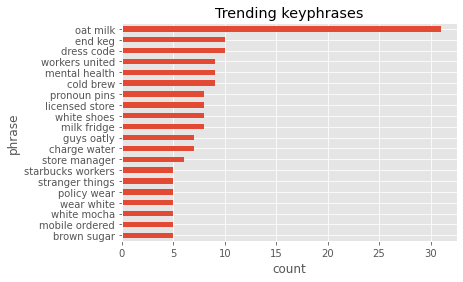

In [17]:
plt.style.use('ggplot')

# render a horizontal bar graph
df_freq.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('Trending keyphrases')
plt.ylabel('phrase')
plt.xlabel('count')
plt.legend().set_visible(False)
plt.show()